## OnionOrNot Using USE & Classifier DL Approach

Project Objective: to correctly classify if a title is for an Onion news article or not.  

Dataset Source: https://www.kaggle.com/datasets/chrisfilo/onion-or-not

##### Import Necessary Libraries

In [0]:
import pandas as pd

import pyspark
from pyspark.sql.types import StructType, StructField, StringType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##### Versions of Libraries, Modules, Frameworks Used in This Project

In [0]:
print("Spark NLP version".rjust(24), sparknlp.version())
print(f"Apache Spark version:".rjust(24), spark.version)

       Spark NLP version 4.2.4
   Apache Spark version: 3.2.1


#### Create Functions Used Throughout This Project

##### Create Function to Ingest Dataset

In [0]:
def ingest_dataset(file_location: str, schema: StructType) -> pyspark.sql.dataframe.DataFrame:
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "true"
    delimiter = ","
    
    dataset = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sep", delimiter) \
      .schema(schema) \
      .load(file_location)
    
    dataset = dataset.na.drop(how='any')
    
    return dataset

##### Create Function to Remove Class Imbalance

In [0]:
def balance_dataset(dataset, unique_label_values, new_schema, samples = 20000, label_col = "label"):
    temp_df =  spark.createDataFrame([], new_schema)
    new_df =  spark.createDataFrame([], new_schema)
    
    for ulab in unique_label_values:
        # extract df of only the desired labels
        temp_df = dataset.where(F.col(label_col).isin(ulab))
        
        ratio = round(samples/temp_df.count(),4)
        # sample it to desired number of samples
        if ratio > 1.0:
            # Oversample
            temp_df = temp_df.sample(True, ratio, seed=42)
        elif ratio < 1.0:
            # Undersample
            temp_df = temp_df.sample(False, ratio, seed=42)
        elif ratio == 1.0:
            # Just use the existing dataframe
            pass
        # concatenate it to the new_df
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    return new_df

##### Metrics Evaluation Function

In [0]:
def metrics_eval(prediction: pd.Series, \
                 label: pd.Series, \
                 model_name: str, \
                 label_values: []\
                ) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
       & F1-score, among others)
    - Confusion Matrix
    '''
    
    from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
    
    print("-------------------------------------------------------------------------------------")
    print("| " + ("The %s Model" % model_name).center(81) + " |")
    print("-------------------------------------------------------------------------------------")
    print("| " + f"Classification Report for the {model_name} Model".center(81) + " |")
    print("-------------------------------------------------------------------------------------\n")

    if label_values != []:
        report = classification_report(label, prediction, zero_division=1, target_names=label_values)
    else:
        report = classification_report(label, prediction, zero_division=1)
    print(report)

    print("-------------------------------------------------------------------------------------")

    print("| " + f"Confusion Matrix for the {model_name} Model".center(81) + " |")
    cm = confusion_matrix(label, prediction)
    
    if label_values != []:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values)
    else:
        dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()

    print("-------------------------------------------------------------------------------------")

#### Prepare Data For Model

##### Ingest & Preprocess Data

In [0]:
data_file = "/FileStore/tables/OnionOrNot.csv"

orig_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
])

df = ingest_dataset(data_file, orig_schema)

df = df.where("label==0 or label==1")

df = df.na.drop() 

df = df.withColumn("text_length", F.size(F.split(F.col('text'), ' ')))

display(df)

text,label,text_length
Entire Facebook Staff Laughs As Man Tightens Privacy Settings,1,9
Muslim Woman Denied Soda Can for Fear She Could Use It as a Weapon,0,14
Bold Move: Hulu Has Announced That They’re Gonna Go Ahead And Reboot ‘Shrill’ While It’s Still On Since You Idiots Will Watch Anything,1,23
Despondent Jeff Bezos Realizes He’ll Have To Work For 9 Seconds To Earn Back Money He Lost In Divorce,1,19
"For men looking for great single women, online dating offers a viable solution to the otherwise frustrating task of finding long-term love. A0rNsK5",1,23
Kim Jong-Un Wonders If Nuclear Threats Distracting Him From Real Goal Of Starving Citizenry,1,14
"Omaha dad finds pot brownies, eats 4 of them, says mean things to cat",0,14
"Pokémon Go player stabbed, keeps playing",0,6
Job Placement Service Helps Students Who Fail Out Of Dad’s Alma Mater Find Work At Dad’s Company,1,17
Idiot Zoo Animal With Zero Predators Still Protective Of Young,1,10


Output can only be rendered in Databricks

Output can only be rendered in Databricks

##### Trim Overly Lengthy Samples from Dataset & Final Preprocessing/Cleanup

In [0]:
df = df.filter(df.text_length < 40)
df = df.drop(df.text_length)

print(f"There are {df.count()} samples in this dataset at this time.\n")
df.printSchema()

There are 23843 samples in this dataset at this time.

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)



##### Remove Class Imbalance

In [0]:
bal_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
])

df = balance_dataset(df, ["0", "1"], bal_schema, samples = 14800, label_col = "label")

##### Print Number of Samples in Dataset & Dataset Schema

In [0]:
df.printSchema()
df.count()

root
 |-- text: string (nullable = true)
 |-- label: string (nullable = true)

Out[13]: 29764

##### Split Dataset into Training & Testing Dataset

In [0]:
train_ds, test_ds = df.randomSplit(weights=[0.80, 0.20], seed=42)

train_ds = train_ds.persist()
test_ds = test_ds.persist()

print(train_ds.count())
print(test_ds.count())

23779
5985


##### Basic Values/Constants

In [0]:
NUM_OF_EPOCHS = 16
BATCH_SIZE = 64

##### Define Piepline Stages

In [0]:
doc = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained(lang="en") \
        .setInputCols(["document"])\
        .setOutputCol("sentence_embeddings")

doc_clf = ClassifierDLApproach() \
    .setInputCols("sentence_embeddings") \
    .setOutputCol("class") \
    .setLabelColumn("label") \
    .setBatchSize(BATCH_SIZE) \
    .setMaxEpochs(NUM_OF_EPOCHS)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


##### Build Pipeline for Training

In [0]:
nlp_clf_pipeline = Pipeline(stages=[doc, use, doc_clf])

##### Fit/Train Model

In [0]:
nlp_clf_model = nlp_clf_pipeline.fit(train_ds)

##### Predictions Using Testing Dataset

In [0]:
predictions = nlp_clf_model.transform(test_ds)

##### Convert Predictions to Pandas DataFrame & Only Return Necessary Features

In [0]:
predictions_in_pandas = predictions.select(F.col('label').alias("ground_truth"), F.col("class.result").alias("prediction")).toPandas()
predictions_in_pandas['prediction'] = predictions_in_pandas['prediction'].apply(lambda x : x[0])
display(predictions_in_pandas)

ground_truth,prediction
0,1
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,0
0,1


##### Calculate & Display Classification Report

-------------------------------------------------------------------------------------
|                 The Onion Or Not Using USE & CLF DL Approach Model                |
-------------------------------------------------------------------------------------
|    Classification Report for the Onion Or Not Using USE & CLF DL Approach Model   |
-------------------------------------------------------------------------------------

              precision    recall  f1-score   support

   Not Onion       0.88      0.86      0.87      3019
       Onion       0.86      0.88      0.87      2966

    accuracy                           0.87      5985
   macro avg       0.87      0.87      0.87      5985
weighted avg       0.87      0.87      0.87      5985

-------------------------------------------------------------------------------------
|      Confusion Matrix for the Onion Or Not Using USE & CLF DL Approach Model      |
----------------------------------------------------------------------

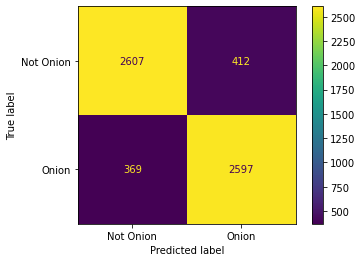

In [0]:
metrics_eval(predictions_in_pandas['ground_truth'], predictions_in_pandas['prediction'], "Onion Or Not Using USE & CLF DL Approach", ["Not Onion", "Onion"])

##### Unpersist Datasets & End Spark Session

In [0]:
train_ds = train_ds.unpersist()
test_ds = test_ds.unpersist()
spark.stop()

### Notes & Other Takeaways From This Project
****
- The results are pretty good. I saw a pretrained model to discern between real and fake news (https://nlp.johnsnowlabs.com/2020/07/03/classifierdl_use_fakenews_en.html). An F1 score of 0.88 was the best F1 score that that data scientist was able to acheive.
****